# Procesado Espectros Raman NANOBASE

In [3]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Directorio en el que se encuentran guardados los datos de Raman
path_nanobase = '/Users/drea/Library/CloudStorage/OneDrive-UNICAN/RamanNanoBase/CONCHAS'
# Obtén la lista de archivos en la carpeta
files = os.listdir(path_nanobase)
# Filtrar solo los archivos CSV
csv_files = [f for f in files if f.endswith('.CSV')]

def nombre_muestra(csv_file):
    file = csv_file.split("_")[1]
    nombre = re.sub(r'(\D)(\d)', r'\1 \2', file)
    muestra = nombre.capitalize()
    return muestra


In [5]:
# Cargar los datos de Raman
csv_files
dataframes = []
i=1
for csv_file in csv_files:

    df = pd.read_csv(os.path.join(path_nanobase, csv_file), engine='python', sep=',', skiprows=14, decimal='.')
    # Eliminar columna no deseada
    if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])
    nombre = nombre_muestra(csv_file)
    df['Muestra'] = f'{nombre} {i}'
    dataframes.append(df)
    data = pd.concat(dataframes)
    i+=1
data.set_index(['Muestra', 'X', 'Y'], inplace=True)

# Eliminar columnas no deseadas
data.drop(columns=['Z', 'XINDEX', 'YINDEX', 'ZINDEX'], inplace=True)

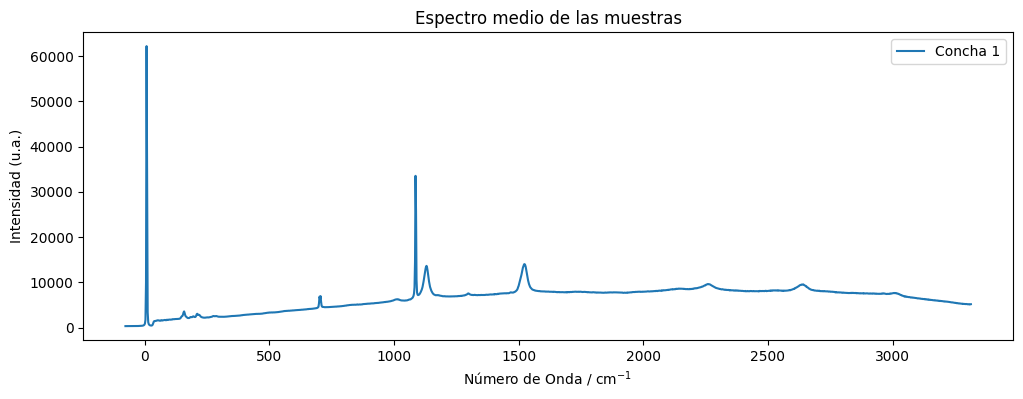

In [6]:
#################### Pintar espectros medios #############################
def avg_spectrum (data,
                  muestras, 
                  titulo = "Espectro medio de las muestras"):
  #data = pd.concat(dataframes, axis=0)
  #data = create_df(csv_files, path)

  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)
    #color = colores[i % len(colores)]

    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}')#, color=color)

  # Etiquetas y título para el gráfico
  plt.xlabel("Número de Onda / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  plt.title(f'{titulo}')

  plt.legend()
  plt.grid(False)
  plt.show()


avg_spectrum(data, muestras =['Concha 1'])